In [1]:
# !pip install --upgrade pandas

In [2]:
!pip install pyarrow

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install scikit-plot

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
#from numpy import nan as NA
import os
import gc
from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

from azure.storage.blob import BlockBlobService
import pyarrow.parquet as pq
from io import StringIO
from io import BytesIO

%matplotlib inline

In [5]:
#!pip install Keras

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#ModelCheckpoint

Using TensorFlow backend.


In [7]:
import scikitplot as skplt

In [8]:
#Azure account credentials
azure_storage_account_name = "agedatasciencecocstorage"
azure_storage_account_key = "V/FXG+lIWtYc854wbRA8BxGCLGJijS0NDwLvNHfmAxqRopAL3WHWGIQoHxpArG9lZoX+iY+dvtPYoB379w4MIw=="

if azure_storage_account_name is None or azure_storage_account_key is None:
    raise Exception("You must provide a name and key for an Azure Storage account")

In [9]:
# First, we need to connect to our blob via the BlobService
blob_service = BlockBlobService(azure_storage_account_name, azure_storage_account_key)
# There are also methods to list containers and blobs
#containers = blob_service.list_containers()
blobs = blob_service.list_blobs('banking-dm')

In [10]:
# # List the blobs in the container.
# print("\nList blobs in the container")
# #generator = block_blob_service.list_blobs(container_name)
# for blob in blobs:
#     print("\t Blob name: " + blob.name)

### Read Data

In [11]:
container_name = "banking-dm"

In [12]:
blob_name_parquet = 'ailiev/3M_AVG_MCIF_2018-01__2018-03.parquet.gzip' 
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet, stream=byte_stream)
    df = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [13]:
df.shape

(100215, 278)

In [14]:
df.head()

,Customer_ID,AGE_MONTHS,SECTOR,CUSTOMER_ECO_BRANCH,MARITAL_STATUS,GENDER,CUSTOMER_CATEGORY,CUSTOMER_TYPE,AT_LEAST_ONE_ACTIVE,AVG_DEPOSITS_minus_LOANS,...,TOTAL_SAVING_BAL,TOTAL_SAVING_CNT,TOTAL_TNAM,CLOSED_MONTHS_MIN,DC_MATURE_MONTHS_MAX,MATURE_MONTHS_MAX,MATURE_MONTHS_MIN,MONTHS_TILL_EXP_MAX,MONTHS_TILL_EXP_MIN,AVG_PERIOD
0,1,558,Arts and Communications,BR160,Divorced,F,None,Individual,0.666667,157.725083,...,37.805250,1.0,1026.335000,-1,-1,54,0,-1,-1,2018-01--2018-03
1,2,519,Finance,BR09,Married,M,None,Professional,1.000000,0.000000,...,0.000000,1.0,161.413333,-1,59,215,213,-1,-1,2018-01--2018-03
2,3,310,Manufacturing,BR145,Married,M,None,Individual,1.000000,1616.158533,...,1616.158533,1.0,3606.596667,-1,-1,229,227,-1,-1,2018-01--2018-03
3,4,484,Health and Science,BR14,None,None,Retail,Small Business,1.000000,-271.317717,...,208.618900,1.0,3869.115000,-1,93,120,0,17,-18,2018-01--2018-03
4,5,477,Agriculture and Food,BR171,Single,M,None,Individual,1.000000,-836.073333,...,0.000000,1.0,1923.821667,-1,-1,171,68,2,-1,2018-01--2018-03


In [15]:
pd.value_counts(df['CUSTOMER_TYPE'])

Individual        84302
Small Business    15410
Professional        503
Name: CUSTOMER_TYPE, dtype: int64

In [16]:
#remove SBBs
df = df[df['CUSTOMER_TYPE']=="Individual"]

In [17]:
df.shape

(84302, 278)

In [18]:
blob_name_parquet_label = 'ailiev/MG_Offer_5.parquet.gzip'
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet_label, stream=byte_stream)
    label = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [19]:
label.shape

(84302, 2)

In [20]:
#label.head()

In [21]:
df = df.merge(label, on="Customer_ID")

In [22]:
#df.head()

In [23]:
df.shape

(84302, 279)

### Analysis

In [24]:
del df['AVG_PERIOD']

In [25]:
demographic_columns = ['Customer_ID', 'CUSTOMER_TYPE', 'CUSTOMER_CATEGORY', 'GENDER', 'MARITAL_STATUS', 'CUSTOMER_ECO_BRANCH', 'SECTOR', 'AGE_MONTHS', 
                      'MG_OFFER']

In [26]:
indep_columns = [col for col in df.columns if col not in demographic_columns]

In [27]:
len(indep_columns)

269

In [28]:
#replaces inf with nan
df.replace( -np.inf, np.nan, inplace=True)

In [29]:
df.fillna(0, inplace=True)

In [30]:
# Create independent and target sets
independents = df[indep_columns].values
target = df['MG_OFFER'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(independents, target, test_size=0.25, random_state=13579)

In [32]:
independents.shape

(84302, 269)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [34]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Keras Sequential

In [ ]:
classifier = Sequential()
classifier.add(Dense(units=20, activation='relu', input_dim = 269))
classifier.add(Dense(units=20, activation='relu'))
# classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))

In [ ]:
classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
classifier.fit(X_train, y_train, batch_size=50, epochs=10)

In [ ]:
classifier.summary()

In [ ]:
prob_y = classifier.predict(X_test)
prob_y = [1 if y>=0.5 else 0 for y in prob_y]

In [ ]:
print(metrics.classification_report(y_test, prob_y,target_names=["False", "True"]))

In [ ]:
confusion = metrics.confusion_matrix(y_test, prob_y)
print("Confusion matrix:\n{}".format(confusion))

In [ ]:
#predicted_probas[1,0]
predicted_probas = classifier.predict_proba(X_test)
predicted_probas=[p[0] for p in predicted_probas]

In [ ]:
probas = pd.DataFrame(predicted_probas)
probas[1] = 1 - probas[0]
probas = probas[[1, 0]]

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
skplt.metrics.plot_cumulative_gain(y_test, probas.values)
plt.show()

# NEW APPROACH

In [36]:
# For custom metrics
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [37]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [78]:
def build_model():
    model = Sequential([
        Dense(units=60, activation='relu', input_dim =X_train.shape[1]),
#         Dropout(0.3),
#         Dense(units=10, activation='relu'),
#         Dropout(0.5),
        Dense(units=20, activation='relu'),
#         Dropout(0.5),
        Dense(units=10, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])
    model.compile(optimizer='rmsprop', # optimizer='sgd',
                loss='binary_crossentropy', 
                metrics=['accuracy', mean_pred, auc])
    return model

In [79]:
model = build_model()

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 60)                16200     
_________________________________________________________________
dense_14 (Dense)             (None, 20)                1220      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 17,641
Trainable params: 17,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

In [41]:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

In [67]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='auc', patience=5, mode='max')

In [ ]:
# !pip install h5py
# from keras.callbacks import ModelCheckpoint

In [ ]:
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# import tensorflow as tf

In [ ]:
# print(tf.__version__)

In [99]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print(epoch+1, end=' ')

EPOCHS = 200

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=100,
    callbacks=[early_stop, PrintDot()])
#   callbacks=[early_stop, model_checkpoint, PrintDot()])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

In [100]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,val_loss,val_acc,val_mean_pred,val_auc,loss,acc,mean_pred,auc,epoch
7,0.409501,0.895303,0.076244,0.771873,0.257488,0.919237,0.092962,0.771875,7
8,0.375966,0.896094,0.099228,0.771874,0.258099,0.918861,0.093386,0.771869,8
9,0.407960,0.887870,0.104938,0.771878,0.262767,0.919514,0.093165,0.771877,9
10,0.408435,0.889214,0.104506,0.771882,0.265679,0.919316,0.093008,0.771882,10
11,0.408045,0.895856,0.073708,0.771879,0.263230,0.919771,0.093317,0.771885,11
12,0.414370,0.895382,0.075250,0.771868,0.261621,0.919949,0.093283,0.771873,12
13,0.411827,0.891191,0.107978,0.771866,0.264149,0.920087,0.092789,0.771863,13
14,0.425793,0.888344,0.102031,0.771870,0.271634,0.919988,0.092540,0.771871,14
15,0.404109,0.893484,0.097272,0.771872,0.269538,0.919751,0.092212,0.771873,15
16,0.427928,0.886446,0.112456,0.771873,0.274083,0.919949,0.092209,0.771875,16


In [101]:
# hist.head(20)

In [102]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('mean_pred')
    plt.plot(hist['epoch'], hist['mean_pred'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_pred'],
             label = 'Val Error')
    plt.ylim([0.05,0.15])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.plot(hist['epoch'], hist['auc'],
             label='Train AUC')
    plt.plot(hist['epoch'], hist['val_auc'],
             label = 'Val AUC')
    plt.ylim([0.68, 0.78])
    plt.legend()
    plt.show()

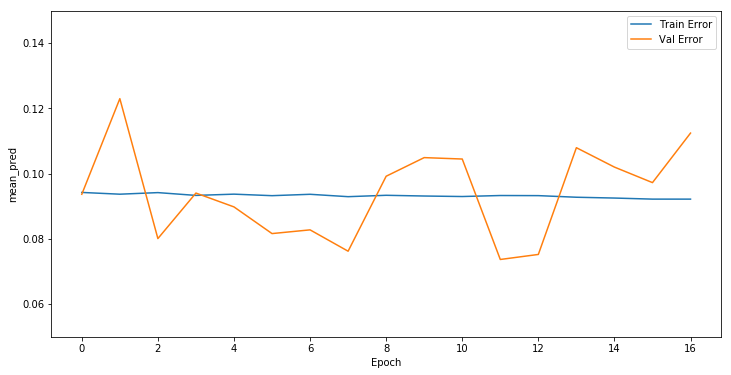

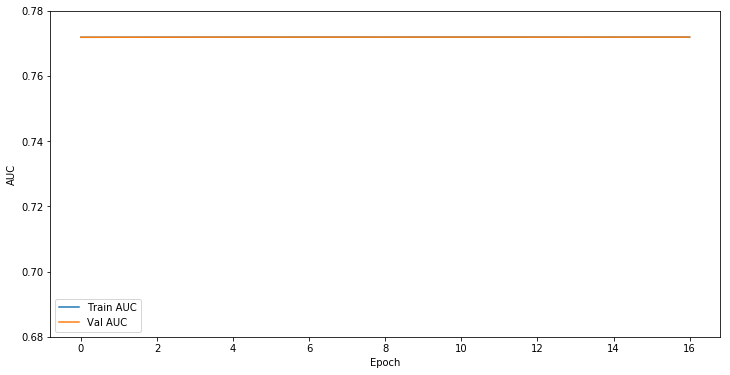

In [103]:
plt.rcParams["figure.figsize"] = (12,6)
plot_history(history)

In [104]:
loss, accuracy, m_pred, auroc = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Accuracy: {:5.2f} ".format(accuracy))
print("Testing set Mean Pred: {:5.4f} ".format(m_pred))
print("Testing set AUC: {:5.4f} ".format(auroc))

Testing set Accuracy:  0.88 
Testing set Mean Pred: 0.1152 
Testing set AUC: 0.7718 


In [105]:
#predicted_probas[1,0]
predicted_probas = model.predict_proba(X_test)
predicted_probas=[p[0] for p in predicted_probas]

In [106]:
probas = pd.DataFrame(predicted_probas)
probas[1] = 1 - probas[0]
probas = probas[[1, 0]]

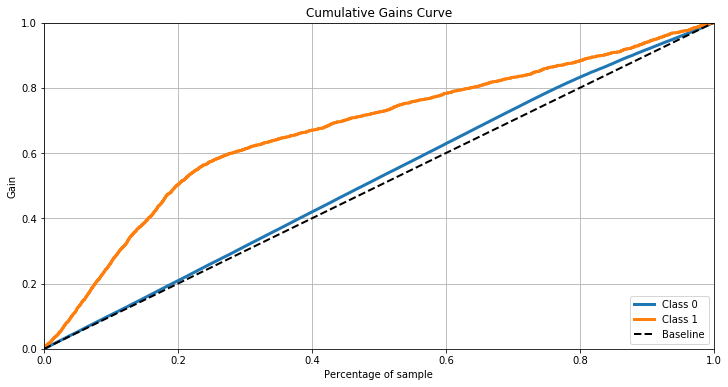

In [107]:
#plt.rcParams["figure.figsize"] = (12,6)
skplt.metrics.plot_cumulative_gain(y_test, probas.values)
plt.show()

In [77]:
del model